# Train Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Define LeNet-5 model
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # 6x24x24 → 6x12x12
        x = self.pool(torch.relu(self.conv2(x)))  # 16x8x8 → 16x4x4
        x = x.view(-1, 16 * 4 * 4)  # Flatten
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


# Split training set into training and validation (90% train, 10% val)
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to evaluate accuracy
def evaluate(model, dataloader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Train the model
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_acc = evaluate(model, trainloader, device)
    val_acc = evaluate(model, valloader, device)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(trainloader):.4f}, Train Acc: {train_acc*100:.2f}%, Val Acc: {val_acc*100:.2f}%")

# Evaluate on test set
test_acc = evaluate(model, testloader, device)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Save the model weights
torch.save(model.state_dict(), "lenet5.pth")
print("Model saved!")

Epoch 1/5, Loss: 0.3513, Train Acc: 96.88%, Val Acc: 96.72%
Epoch 2/5, Loss: 0.0964, Train Acc: 98.03%, Val Acc: 97.65%
Epoch 3/5, Loss: 0.0679, Train Acc: 98.36%, Val Acc: 98.02%
Epoch 4/5, Loss: 0.0530, Train Acc: 98.75%, Val Acc: 98.32%
Epoch 5/5, Loss: 0.0453, Train Acc: 98.77%, Val Acc: 98.49%
Test Accuracy: 98.60%
Model saved!


# Extract Weights

In [ ]:
import torch
import numpy as np

model = LeNet5()
state_dict = torch.load('lenet5.pth', map_location=torch.device('cpu'), weights_only=True)  # Set weights_only=True
model.load_state_dict(state_dict)  # Load the state dictionary
model.eval()

# Extract the weights
conv1_weights = model.conv1.weight.data.numpy()  # Assuming 'conv1' is the first convolutional layer
conv1_biases = model.conv1.bias.data.numpy()
conv2_weights = model.conv2.weight.data.numpy()
conv2_biases = model.conv2.bias.data.numpy()
fc1_weights = model.fc1.weight.data.numpy()
fc1_biases = model.fc1.bias.data.numpy()
fc2_weights = model.fc2.weight.data.numpy()
fc2_biases = model.fc2.bias.data.numpy()
fc3_weights = model.fc3.weight.data.numpy()
fc3_biases = model.fc3.bias.data.numpy()

# Save weights as NumPy arrays
np.savez('lenet_weights.npz',
         conv1_weights=conv1_weights, conv1_biases=conv1_biases,
         conv2_weights=conv2_weights, conv2_biases=conv2_biases,
         fc1_weights=fc1_weights, fc1_biases=fc1_biases,
         fc2_weights=fc2_weights, fc2_biases=fc2_biases,
         fc3_weights=fc3_weights, fc3_biases=fc3_biases)

In [ ]:
import numpy as np

# Load the weights
weights = np.load('lenet_weights.npz')

# Create a C header file to store the weights
with open('lenet_weights.h', 'w') as f:
    # Function to convert NumPy arrays to C arrays
    def array_to_c(array, name):
        def format_array(arr, indent=0):
            if arr.ndim == 1:  # Base case: 1D array
                return "{" + ", ".join(f"{x:.8f}" for x in arr) + "}"
            else:
                # Recursive case: Multi-dimensional array
                lines = [format_array(sub_arr, indent + 4) for sub_arr in arr]
                return "{\n" + ",\n".join(" " * (indent + 4) + line for line in lines) + "\n" + " " * indent + "}"

        shape_str = str(array.shape).replace('(', '[').replace(')', ']')
        shape_str = shape_str.replace(', ', '][')  # Replace commas with ][ for C array declaration
        # Remove trailing comma for 1D arrays
        if array.ndim == 1:
            shape_str = shape_str[:-2] + "]"  # Remove the trailing "]," and add "]"


        f.write(f"float {name}{shape_str} = ")
        f.write(format_array(array) + ";\n\n")

    # Convert and write the weights to the header file
    array_to_c(weights['conv1_weights'], 'conv1_weights')
    array_to_c(weights['conv1_biases'], 'conv1_biases')
    array_to_c(weights['conv2_weights'], 'conv2_weights')
    array_to_c(weights['conv2_biases'], 'conv2_biases')
    array_to_c(weights['fc1_weights'], 'fc1_weights')
    array_to_c(weights['fc1_biases'], 'fc1_biases')
    array_to_c(weights['fc2_weights'], 'fc2_weights')
    array_to_c(weights['fc2_biases'], 'fc2_biases')
    array_to_c(weights['fc3_weights'], 'fc3_weights')
    array_to_c(weights['fc3_biases'], 'fc3_biases')

print("Weights saved to lenet_weights.h")

Weights saved to lenet_weights.h


# Export Image

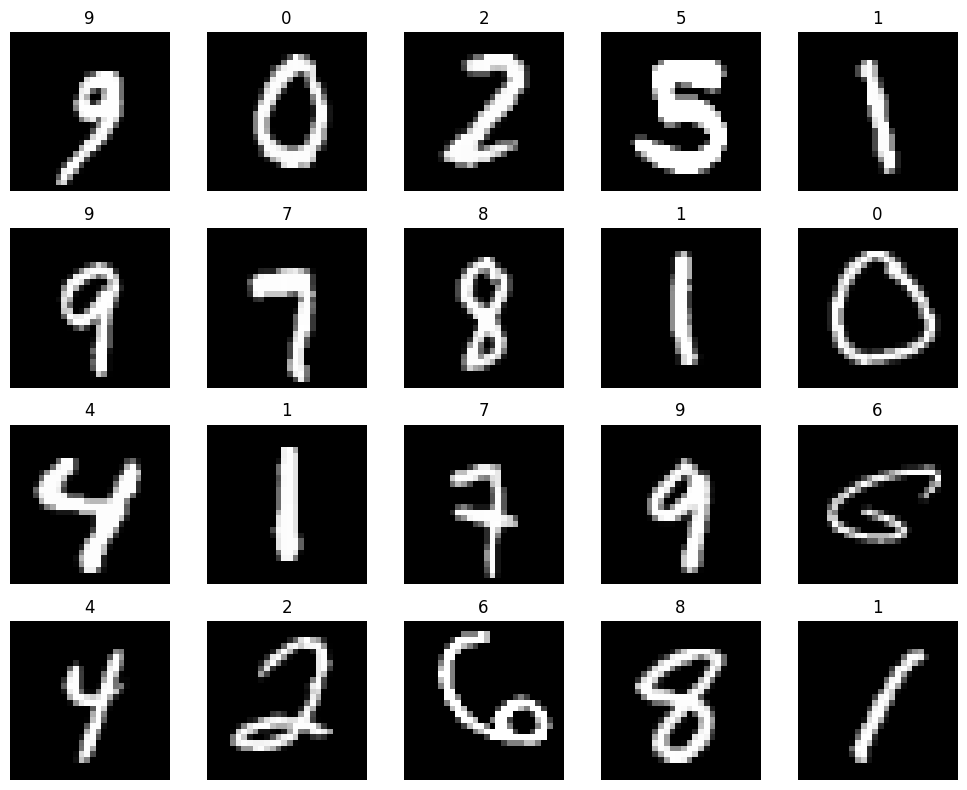

In [ ]:
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

# Load the MNIST testing dataset
transform = transforms.Compose([transforms.ToTensor()])
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Display the first 20 images
fig, axes = plt.subplots(4, 5, figsize=(10, 8))  # Create a 4x5 grid of subplots
axes = axes.flatten()  # Flatten the 2D array of subplots to 1D

for i in range(20):
    image, label = testset[i + 1000]  # Get the image and label
    axes[i].imshow(image.squeeze(), cmap='gray')  # Display the image
    axes[i].axis('off')  # Turn off axis labels
    axes[i].set_title(label)  # Set the title to the label

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()  # Show the plot

In [ ]:
from PIL import Image
import numpy as np

test_image = torchvision.datasets.MNIST(root='./data', train=False, download=True)
image, label = test_image[61]  # Get the first image and its label

# Convert to NumPy array
image_np = np.array(image)

# Flatten the array to 1D
image_c = image_np.flatten()

# Convert the array to a C-compatible format with newlines and aligned commas
c_array = "{ "
for i, value in enumerate(image_c):
    c_array += "{:3d}, ".format(value)  # Pad with spaces to align commas
    if (i + 1) % 28 == 0:
        c_array += "\n"  # Add a newline every 28 elements
c_array = c_array[:-2] + " }"  # Remove the last comma and space, then add the closing brace

print(c_array)

{   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 
  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 
  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 
  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 
  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 
  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  43,  47,  47,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 
  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   9, 108, 249, 253, 253, 208, 207, 207, 207, 149,  65,  13,   0,   0,   0,   0,   0, 
  0,   0,  

# Debug

In [ ]:
def conv1_output_hook(module, input, output):
    print("Conv1 output shape:", output.shape)
    output_np = output.cpu().detach().numpy()

    # Extract the desired slice (first channel, 24x24)
    data = output_np[0, 0, :24, :24]

    # Format the output as a comma-separated list with newlines
    formatted_output = "["  # Start with an opening bracket
    for row in data:
        formatted_output += "[" + ", ".join(f"{x:8.1f}" for x in row) + "],\n"  # Add newline
    formatted_output = formatted_output[:-2] + "]"  # Remove last comma and newline, add closing bracket

    print(formatted_output)

def pool1_output_hook(module, input, output):
    print("Pool1 output shape:", output.shape)
    output_np = output.cpu().detach().numpy()
    print(output_np[0, 0, :12, :12])

def conv2_output_hook(module, input, output):
    print("Conv2 output shape:", output.shape)
    output_np = output.cpu().detach().numpy()
    print("Some values from Conv2 output:")
    print(output_np[0, 0, :8, :8])

def pool2_output_hook(module, input, output):
    print("Pool2 output shape:", output.shape)
    output_np = output.cpu().detach().numpy()
    print("Some values from Pool2 output:")
    print(output_np[0, 0, :4, :4])

def fc1_output_hook(module, input, output):
    print("FC1 output shape:", output.shape)
    output_np = output.cpu().detach().numpy()
    print("Some values from FC1 output:")
    print(output_np[0, :5])  # Print first 5 values

def fc2_output_hook(module, input, output):
    print("FC2 output shape:", output.shape)
    output_np = output.cpu().detach().numpy()
    print("Some values from FC2 output:")
    print(output_np[0, :5])  # Print first 5 values

def fc3_output_hook(module, input, output):
    print("FC3 output shape:", output.shape)
    output_np = output.cpu().detach().numpy()
    print("Some values from FC3 output:")
    print(output_np[0, :10])

In [ ]:
# Register the hooks
# handle_conv1 = model.conv1.register_forward_hook(conv1_output_hook)
# handle_pool1 = model.pool.register_forward_hook(pool1_output_hook) # For the first pooling layer
# handle_conv2 = model.conv2.register_forward_hook(conv2_output_hook)
# handle_pool2 = model.pool.register_forward_hook(pool2_output_hook)  # For the second pooling layer
# handle_fc1 = model.fc1.register_forward_hook(fc1_output_hook)
# handle_fc2 = model.fc2.register_forward_hook(fc2_output_hook)
# handle_fc3 = model.fc3.register_forward_hook(fc3_output_hook)

image_tensor = torch.from_numpy(image_np).float() / 255.0
print(image_tensor)
image_tensor = image_tensor.unsqueeze(0).unsqueeze(0)

with torch.no_grad():
    output = model(image_tensor)

_, predicted = torch.max(output, 1)
predicted_class = predicted.item()

print(f"Predicted class: {predicted_class}")

# Remove the hooks
# handle_conv1.remove()
# handle_pool1.remove()
# handle_conv2.remove()
# handle_pool2.remove()
# handle_fc1.remove()
# handle_fc2.remove()
# handle_fc3.remove()

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [ ]:
# Load the saved model weights
model = LeNet5()  # Assuming LeNet5 is your model class
model.load_state_dict(torch.load("lenet5.pth"))

# Access the conv1 weights and print them
conv1_weights = model.conv1.weight
print(conv1_weights)

Parameter containing:
tensor([[[[-0.0750,  0.2092,  0.2938,  0.2677,  0.3571],
          [-0.5367, -0.4911,  0.0321,  0.0734,  0.2556],
          [-0.1879, -0.7519, -0.6592, -0.3133, -0.0702],
          [ 0.0607, -0.0856, -0.4748, -0.4505, -0.4054],
          [ 0.4209,  0.2112,  0.2973,  0.0313, -0.0994]]],


        [[[ 0.2050,  0.0804,  0.4202,  0.4437,  0.3386],
          [ 0.0995,  0.3539,  0.3723,  0.1309,  0.2688],
          [ 0.2532, -0.0321, -0.1855, -0.2371, -0.1188],
          [-0.3071, -0.3966, -0.4237, -0.2394, -0.1236],
          [-0.1013, -0.2184, -0.3528, -0.1948, -0.0066]]],


        [[[-0.0260,  0.1901,  0.2594, -0.0635,  0.1591],
          [ 0.1697,  0.2230,  0.0068,  0.2553,  0.1468],
          [-0.2522, -0.1651, -0.0031,  0.2432, -0.0330],
          [-0.0139, -0.0478,  0.1829,  0.3259, -0.1146],
          [-0.3358,  0.0285, -0.1881,  0.2433,  0.0727]]],


        [[[-0.0646,  0.1697,  0.0476,  0.2687, -0.2904],
          [ 0.1782,  0.3334,  0.2861,  0.0723, -0.1772

In [ ]:
import gc
del model
gc.collect()
torch.cuda.empty_cache()